In [1]:
import math
from tqdm import tqdm
from datetime import datetime
import pandas as pd
import numpy as np
import os
import torch
import sentence_transformers
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline
import torch.nn as nn

from transformers import BertTokenizer, BertModel, pipeline
from transformers import RobertaTokenizer, RobertaModel, AutoConfig
from transformers import AutoTokenizer, AutoModel
from transformers import DebertaConfig
from transformers import BartTokenizer, BartModel

from sentence_transformers.util import cos_sim
from sentence_transformers import SentenceTransformer, models
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics.pairwise import cosine_similarity
import torch.nn.functional as F
from DeBERTa import deberta
from collections import OrderedDict

import textstat

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [3]:
# model_name = 'facebook/bart-base'
model_name = r"C:\Users\shmak\.~DeBERTa\assets\latest\deberta-base\pytorch_model.bin"
# model_name = 'deberta-v3-base\pytorch_model.bin'

In [4]:
# def config_model():
#     configuration = AutoConfig.from_pretrained(model_name)
#
#     configuration.hidden_dropout_prob = 0.0
#     configuration.attention_probs_dropout_prob = 0.0
#     configuration.classifier_dropout = 0.0
#
#     return configuration
#
# config = config_model()
# size = config.hidden_size

In [5]:
def config_debert():
    configuration = deberta.ModelConfig()
    # configuration = DebertaV2Config()
    # configuration = configuration.from_json_file(r"C:\Users\shmak\.~DeBERTa\assets\latest\deberta-base\model_config.json")
    configuration = configuration.from_json_file('deberta-v3-base\config.json')

    configuration.attention_probs_dropout_prob = 0.0
    configuration.hidden_dropout_prob = 0.0

    return configuration

config = config_debert()
size = config.hidden_size

In [6]:
# tokenizer = BartTokenizer.from_pretrained(model_name)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# tokenizer = RobertaTokenizer.from_pretrained()

In [7]:
def debert_init(config):
    state_dict = torch.load(model_name)

    state_dict_new = {}

    for key, value in state_dict.items():
        if key.startswith('deberta.'):
            state_dict_new[key.removeprefix('deberta.')] = value

    embeddings_model = deberta.DeBERTa(config=config)

    embeddings_model.load_state_dict(state_dict=state_dict_new)

    return embeddings_model

In [8]:
# DeBERTa model
#
# vocab_path, vocab_type = deberta.load_vocab(pretrained_id='large')
# tokenizer = deberta.tokenizers[vocab_type](vocab_path)
# embeddings_model = DebertaV2Model(config)


## Data

In [9]:
summaries_train_path = r"dataset\summaries_train_merged.csv"
summaries_test_path = r"dataset\summaries_test.csv"
prompts_train_path = r"dataset\prompts_train.csv"
prompts_test_path = r"dataset\prompts_test.csv"

In [10]:
def norm_score(df: pd.DataFrame) -> pd.DataFrame:
    """Normilizing score to values 0 to 1"""
    df -= np.min(df)
    df /= df.max()
    print('Normilized' if df.min() == 0.0 and df.max() == 1.0 else 'NormError:wrong values')

    return df

def short_text(text, max_length=200) -> str:
    if len(text.split()) > 700:
        middle_point = text[len(text)//2:].index('.') + len(text)//2 + 1
        text_pt1 = text[:middle_point]
        text_pt2 = text[middle_point:]

        text = short_text(text_pt1) + short_text(text_pt2)

    summarizer = pipeline("summarization", model="bart-large-cnn")

    # summarizer.model.to(device)

    summarized = summarizer(text, max_length=max_length, min_length=80, do_sample=False)

    return summarized[0]['summary_text']

def moving_average(array: np.array, betta=0.9) -> np.array:
    """
    Computing moving average with bias correction.
    """

    V = 0
    average_array = np.zeros(len(array))
    for i in range(len(array)):
        V = betta * V + (1 - betta) * array[i]
        average_array[i] = V/(1 - pow(betta, i+1))

    return average_array


def mean_pooling(outputs, batch) -> torch.tensor:

    attention_mask = batch['attention_mask']
    embeddings = outputs['hidden_states'][-1]
    # embeddings = outputs.last_hidden_state

    mask = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
    masked_embeddings = embeddings * mask

    summed = torch.sum(masked_embeddings, 1)
    summed_mask = torch.clamp(mask.sum(dim=1), min=1e-9)

    mean_pooled = summed/summed_mask

    return mean_pooled

def normilize(df_column: pd.DataFrame):

    df_column = (df_column - df_column.mean())/df_column.std()

    return df_column

def get_cos_sim(df):
    sentence_1 = df.text
    sentence_2 = df.prompt_text

    sentence_tokenizer = AutoTokenizer.from_pretrained('all-mpnet-base-v2')
    sentence_model = AutoModel.from_pretrained('all-mpnet-base-v2')

    cos_sim_list = []
    sentence_model.to(device)

    for i, summarie in enumerate(tqdm(sentence_1)):
        prompt = sentence_2[i]
        inputs = sentence_tokenizer([summarie, prompt], padding=True,
                                    return_tensors='pt', truncation=True)
        inputs.to(device)

        with torch.no_grad():
            outputs = sentence_model(**inputs)

        sentence_embeddings = mean_pooling(outputs, inputs)
        sentence_embeddings = F.normalize(sentence_embeddings)

        score = nn.CosineSimilarity(dim=0)(sentence_embeddings[0], sentence_embeddings[1])

        cos_sim_list.append(score.item())

    return cos_sim_list

def get_stat_features(df, text_col="text"):

    df["num_unique_words"] = normilize(df[text_col].apply(lambda x: len(set(x.split()))))
    df["num_words"] = normilize(df[text_col].apply(lambda x: len(x.split())))
    df["num_sentences"] = normilize(df[text_col].apply(lambda x: len(x.split('.'))))

    df["syntax_count"] = normilize(df[text_col].apply(lambda x: x.count(",")
                                                      + x.count("-") + x.count(";") + x.count(":")))
    df['smog_index'] = normilize(df[text_col].apply(lambda x: textstat.smog_index(x)))
    # df['cos_sim'] = normilize(pd.DataFrame(get_cos_sim(df)))

    return df

In [11]:
class SentenseData(Dataset):
    """
    :params: path to csv file with summaries, path to csv file with prompts, 'score' param\
    defines which score is used: content/wording
    """
    def __init__(self, summaries_path=summaries_train_path,
                 prompts_path=prompts_train_path,
                 score='wording', test=False, fold_test='ebad26'):
        self.test = test
        self.score_type = score
        self.fold_test = fold_test

        with open(prompts_path, encoding='utf-8') as f:
            self.prompts = pd.read_csv(f)

        with open(summaries_path, encoding='utf-8') as f:
            summaries = pd.read_csv(f)
            self.summaries = summaries

    def __len__(self):
        return len(self.__summaries)

    @property
    def summaries(self):
        return self.__summaries

    @summaries.setter
    def summaries(self, df):
        if self.test:
            self.__summaries = df[df.prompt_id == self.fold_test].reset_index(drop=True)

        else:
            self.__summaries = df[df.prompt_id != self.fold_test].reset_index(drop=True)

    @property
    def prompts(self):
        return self.__prompts

    @prompts.setter
    def prompts(self, file):
        self.__prompts = file
        # for i, text in enumerate(self.__prompts.prompt_text):
        #     if len(text.split()) > 300:
        #         self.__prompts.prompt_text[i] = short_text(text)

    def get_batch_text(self, index):
        summary_text = self.summaries.text[index]

        if True:#self.score_type == 'wording':
            res = tokenizer(summary_text, padding='max_length', return_tensors='pt', truncation=True)
            res = {k:val.squeeze() for k, val in res.items()}
            res['features'] = torch.tensor([self.summaries['num_unique_words'][index], self.summaries['num_words'][index],
                                  self.summaries['num_sentences'][index],self.summaries['syntax_count'][index],
                                  self.summaries['smog_index'][index]], dtype=torch.float32)

            return res

        prompt_text = self.prompts.prompt_text[self.prompts.prompt_id ==
                                               self.summaries.prompt_id[index]].item().replace('\n','')

        return tokenizer([summary_text, prompt_text], padding='max_length', return_tensors='pt', truncation=True)

    # def get_score(self, index):
    #     if self.score_type == 'content':
    #         score = self.summaries.content[index]
    #
    #     elif self.score_type == 'wording':
    #         score = self.summaries.wording[index]
    #
    #     return torch.tensor(score)

    def get_score(self, index):

        score = [self.summaries.content[index], self.summaries.wording[index]]

        return torch.tensor(score)

    def __getitem__(self, index) -> torch.tensor:

        batch_text = self.get_batch_text(index)
        batch_score = self.get_score(index)

        return batch_text, batch_score

## Model

In [12]:
class STSBertModel(nn.Module):
    """
    Sentence Semantic Similarity Bert model
    :param: seg_head=True for using segmentation head instead of cosine similarity
    :param: freeze_weights=True to freeze BERT model's weights and train only the segmentation head
    """
    def __init__(self, with_features=False, input_size=size):
        super(STSBertModel, self).__init__()

        self.word_embedding = deberta.DeBERTa(config=config_debert(), pre_trained=model_name)
        # self.word_embedding = debert_init(config)

        # self.word_embedding = BartModel.from_pretrained(model_name, config=config)
        self.cos_score = nn.CosineSimilarity(dim=0)
        self.identity = nn.Identity()
        self.input_size = input_size
        self.with_features = with_features

        if with_features:
            self.n_features = 5
            self.input_size += self.n_features

        # for param in self.word_embedding.parameters():
        #     param.requires_grad = False

        self.attention = SelfAttention(self.input_size)
        self.block = AttentionBlock(self.input_size)

        self.FC_head = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(self.input_size, self.input_size)),
            ('relu1', nn.ReLU()),
            # ('fc2', nn.Linear(1024, self.input_size)),
            # ('relu2', nn.ReLU())
            ]))

        self.FC_output = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(self.input_size, 2)),
            ]))

    def forward(self, x):
        output = self.word_embedding(input_ids=x['input_ids'], attention_mask=x['attention_mask'])
        output = mean_pooling(output, x)

        if self.with_features:
            output = torch.cat((output, x['features']), dim=1)

        output = output.unsqueeze(1)
        output = self.attention(output)
        output = self.FC_output(output)

        return output.squeeze()


class AttentionBlock(nn.Module):
    def __init__(self, input_dim):
        super(AttentionBlock, self).__init__()

        self.input_dim = input_dim
        self.fc = nn.Linear(input_dim, input_dim)
        self.attention = SelfAttention(input_dim)
        self.relu = nn.ReLU()
        self.norm = nn.LayerNorm(input_dim)

    def forward(self, x):
        identity = x

        x = self.attention(x)
        x = self.fc(x)

        x += identity
        x = self.norm(x)
        x = self.relu(x)

        return x


class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim ** 0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted


In [13]:
class MCRMSELoss(nn.Module):
    def __init__(self, num_scores=2):
        super().__init__()
        self.MSELoss = nn.MSELoss()
        self.num_scores = num_scores

    def forward(self, y_hat, y):
        score = 0
        for i in range(self.num_scores):
            score += torch.sqrt(self.MSELoss(y_hat[:,i], y[:,i]))

        return score / self.num_scores

## Training

In [14]:
train_dev_split = True

In [15]:
def validate_model(model, loss_func):

    losses_epoch_test = []
    losses_epoch_train_dev = []

    model.eval()
    with torch.no_grad():
        for inputs, targets in test_loader:
            targets = targets.float().to(device)

            inputs = {k:val.squeeze().to(device) for k, val in inputs.items()}

            with torch.autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(inputs)

            loss = loss_func(outputs.squeeze(), targets)

            losses_epoch_test.append(loss.item())

        if train_dev_split:

            for inputs, targets in train_dev_loader:
                targets = targets.float().to(device)

                inputs = {k:val.squeeze().to(device) for k, val in inputs.items()}

                with torch.autocast(device_type='cuda', dtype=torch.float16):
                    outputs = model(inputs)

                loss = loss_func(outputs.squeeze(), targets)

                losses_epoch_train_dev.append(loss.item())

    return losses_epoch_test, losses_epoch_train_dev


def train_model(n_epochs, lr, weight_decay, n_fold, lr_head):

    model = STSBertModel(with_features=True)
    # model = ClassificationModel(n_features=7, n_fold=n_fold)

    model.float()
    model.to(device)

    params = [
        {'params': model.word_embedding.parameters()},
        {'params': model.attention.parameters(), 'lr': lr_head},
        {'params': model.block.parameters(), 'lr': lr_head},
        {'params': model.FC_head.parameters(), 'lr': lr_head},
        {'params': model.FC_output.parameters(), 'lr': lr_head}
    ]

    # loss_func = nn.MSELoss()
    loss_func = MCRMSELoss()

    optimizer = torch.optim.AdamW(params, lr=lr, weight_decay=weight_decay)
    # lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.7, verbose=True)
    # warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, 1e-8, 1, 150, verbose=False)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.7, verbose=False)
    scaler = torch.cuda.amp.GradScaler()

    losses_train = []
    losses_test = []
    losses_train_dev = []

    t0 = datetime.now()

    for i in range(n_epochs):

        losses_train_per_epoch = []

        for j, batch in enumerate(tqdm(train_loader, position=0, leave=True), 1):
            inputs, targets = batch
            targets = targets.float().to(device)

            model.train()

            optimizer.zero_grad()

            with torch.autocast(device_type='cuda', dtype=torch.float16):
                inputs = {k:val.squeeze().to(device) for k, val in inputs.items()}
                outputs = model(inputs)

                loss = loss_func(outputs.squeeze(), targets)

            scaler.scale(loss).backward()
            scaler.step(optimizer)

            scaler.update()

            # lr_scheduler.step()
            # warmup_scheduler.step()
            losses_train_per_epoch.append(loss.item())

            if j%30 == 0 or j == len(train_loader):

                losses_test_per_epoch, losses_test_dev_epoch = validate_model(model, loss_func)
                losses_test_mean = np.mean(losses_test_per_epoch)
                losses_train_mean = np.mean(losses_train_per_epoch)
                if train_dev_split:
                    losses_train_dev_mean = np.mean(losses_test_dev_epoch)

                losses_train.append(losses_train_mean)
                losses_test.append(losses_test_mean)
                if train_dev_split:
                    losses_train_dev.append(losses_train_dev_mean)

                if losses_test_mean == np.min(losses_test):
                    best_score = losses_test_mean
                    n_iter = len(losses_train)
                    torch.save(model.state_dict(), r'models\cv\best__fold_{}.pt'.format(n_fold))
                    print(f'Best saved, loss: {best_score:.5f}')

                losses_train_per_epoch = []

                learning_params_to_print = f'Fold# {n_fold}, Epoch: {i+1}/{n_epochs}, L_train: {losses_train_mean:.5f}, L_test: {losses_test_mean:.5f}'

                if train_dev_split:
                    learning_params_to_print += f', L_train_dev:{losses_train_dev_mean:.5f}'

                print(learning_params_to_print)

        lr_scheduler.step()
        torch.cuda.empty_cache()

    fold_score, _ = validate_model(model, loss_func)
    fold_score = np.mean(fold_score)

    print(f"Time elapsed:{datetime.now()-t0}, Best score:{best_score:.5f}, Fold_score:{fold_score:.5f}")

    return fold_score, best_score, n_iter, losses_test, losses_train, losses_train_dev

In [16]:
def dev_train_split(train_data):
    train_dev_length = int(len(train_data)*0.1)
    train_length = len(train_data) - train_dev_length

    return random_split(train_data, [train_length, train_dev_length])

def loaders_init(score_type, batch_size, fold):

    test_data = SentenseData(test=True, score=score_type, fold_test=fold)
    train_data = SentenseData(score=score_type, fold_test=fold)

    train_dev_loader = None

    if train_dev_split:
        train_data, train_dev_data = dev_train_split(train_data)

        train_dev_loader = DataLoader(train_dev_data,
                                      batch_size=batch_size,
                                      shuffle=True, drop_last=True)

    train_loader = DataLoader(train_data,
                           batch_size=batch_size,
                           shuffle=True, drop_last=True)

    test_loader = DataLoader(test_data,
                          batch_size=batch_size,
                          shuffle=True, drop_last=True)

    return train_loader, test_loader, train_dev_loader

def axis_set(ax):

    ax.plot(test_losses, label='test')
    ax.plot(moving_average(test_losses), label='m/a')
    ax.plot(train_losses, label='train')

    if train_dev_split:
        ax.plot(train_dev_losses, label='train-dev', linestyle='dotted')

    ax.scatter(n_iter - 1, best_score, label='min', color='r')
    ax.set_title(f'#{i}, scr:{fold_score:.4f}, min:{best_score:.4f}', loc='left')
    ax.xaxis.set_major_locator(ticker.LinearLocator(n_epochs + 1))
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(range(n_epochs)))
    ax.legend()

    return ax

08/25/2023 10:08:09|INFO|logging|00| Loaded pretrained model file C:\Users\shmak\.~DeBERTa\assets\latest\deberta-base\pytorch_model.bin
  5%|▌         | 31/574 [00:28<42:49,  4.73s/it]  

Best saved, loss: 0.95571
Fold# 1, Epoch: 1/2, L_train: 1.21108, L_test: 0.95571, L_train_dev:0.90644


 11%|█         | 61/574 [00:55<40:27,  4.73s/it]

Best saved, loss: 0.83571
Fold# 1, Epoch: 1/2, L_train: 0.89037, L_test: 0.83571, L_train_dev:0.85873


 16%|█▌        | 91/574 [01:22<38:04,  4.73s/it]

Best saved, loss: 0.67798
Fold# 1, Epoch: 1/2, L_train: 0.82187, L_test: 0.67798, L_train_dev:0.70817


 21%|██        | 121/574 [01:49<35:04,  4.65s/it]

Fold# 1, Epoch: 1/2, L_train: 0.73240, L_test: 0.70547, L_train_dev:0.72498


 26%|██▋       | 151/574 [02:15<32:46,  4.65s/it]

Fold# 1, Epoch: 1/2, L_train: 0.71867, L_test: 0.90418, L_train_dev:0.88841


 32%|███▏      | 181/574 [02:42<31:07,  4.75s/it]

Best saved, loss: 0.60083
Fold# 1, Epoch: 1/2, L_train: 0.68776, L_test: 0.60083, L_train_dev:0.68303


 37%|███▋      | 211/574 [03:09<27:56,  4.62s/it]

Fold# 1, Epoch: 1/2, L_train: 0.62486, L_test: 0.62005, L_train_dev:0.66732


 42%|████▏     | 241/574 [03:35<25:41,  4.63s/it]

Fold# 1, Epoch: 1/2, L_train: 0.70934, L_test: 0.74490, L_train_dev:0.72285


 47%|████▋     | 271/574 [04:02<23:35,  4.67s/it]

Fold# 1, Epoch: 1/2, L_train: 0.66676, L_test: 0.65074, L_train_dev:0.68317


 52%|█████▏    | 301/574 [04:28<20:59,  4.61s/it]

Fold# 1, Epoch: 1/2, L_train: 0.71044, L_test: 0.65004, L_train_dev:0.68077


 58%|█████▊    | 331/574 [04:54<18:31,  4.57s/it]

Fold# 1, Epoch: 1/2, L_train: 0.68255, L_test: 0.64302, L_train_dev:0.64978


 63%|██████▎   | 361/574 [05:21<16:14,  4.58s/it]

Fold# 1, Epoch: 1/2, L_train: 0.67431, L_test: 0.68345, L_train_dev:0.69800


 68%|██████▊   | 391/574 [05:47<13:57,  4.57s/it]

Fold# 1, Epoch: 1/2, L_train: 0.69017, L_test: 0.62394, L_train_dev:0.64232


 73%|███████▎  | 421/574 [06:13<11:40,  4.58s/it]

Fold# 1, Epoch: 1/2, L_train: 0.65361, L_test: 0.61484, L_train_dev:0.64472


 79%|███████▊  | 451/574 [06:40<09:48,  4.78s/it]

Best saved, loss: 0.59055
Fold# 1, Epoch: 1/2, L_train: 0.59272, L_test: 0.59055, L_train_dev:0.68118


 84%|████████▍ | 481/574 [07:07<07:16,  4.69s/it]

Fold# 1, Epoch: 1/2, L_train: 0.65849, L_test: 0.62834, L_train_dev:0.64555


 89%|████████▉ | 511/574 [07:34<04:53,  4.65s/it]

Fold# 1, Epoch: 1/2, L_train: 0.64634, L_test: 0.61162, L_train_dev:0.64162


 94%|█████████▍| 541/574 [08:00<02:31,  4.60s/it]

Fold# 1, Epoch: 1/2, L_train: 0.62944, L_test: 0.59523, L_train_dev:0.66655


 99%|█████████▉| 571/574 [08:27<00:13,  4.66s/it]

Fold# 1, Epoch: 1/2, L_train: 0.67877, L_test: 0.61111, L_train_dev:0.63984


100%|██████████| 574/574 [08:48<00:00,  1.09it/s]


Fold# 1, Epoch: 1/2, L_train: 0.52094, L_test: 0.61658, L_train_dev:0.66596


  5%|▌         | 31/574 [00:26<41:44,  4.61s/it]

Fold# 1, Epoch: 2/2, L_train: 0.65339, L_test: 0.61367, L_train_dev:0.65205


 11%|█         | 61/574 [00:53<39:24,  4.61s/it]

Fold# 1, Epoch: 2/2, L_train: 0.65508, L_test: 0.60765, L_train_dev:0.65173


 16%|█▌        | 91/574 [01:19<36:49,  4.57s/it]

Fold# 1, Epoch: 2/2, L_train: 0.71372, L_test: 0.61018, L_train_dev:0.65053


 21%|██        | 121/574 [01:45<34:14,  4.54s/it]

Fold# 1, Epoch: 2/2, L_train: 0.63713, L_test: 0.60514, L_train_dev:0.64282


 26%|██▋       | 151/574 [02:11<32:11,  4.57s/it]

Fold# 1, Epoch: 2/2, L_train: 0.61657, L_test: 0.61728, L_train_dev:0.67836


 32%|███▏      | 181/574 [02:37<29:45,  4.54s/it]

Fold# 1, Epoch: 2/2, L_train: 0.65350, L_test: 0.63601, L_train_dev:0.66944


 37%|███▋      | 211/574 [03:03<27:22,  4.53s/it]

Fold# 1, Epoch: 2/2, L_train: 0.63739, L_test: 0.61257, L_train_dev:0.65497


 42%|████▏     | 241/574 [03:29<25:18,  4.56s/it]

Fold# 1, Epoch: 2/2, L_train: 0.62275, L_test: 0.61503, L_train_dev:0.65962


 47%|████▋     | 271/574 [03:55<23:22,  4.63s/it]

Fold# 1, Epoch: 2/2, L_train: 0.66862, L_test: 0.62043, L_train_dev:0.65001


 52%|█████▏    | 301/574 [04:22<20:57,  4.61s/it]

Fold# 1, Epoch: 2/2, L_train: 0.65904, L_test: 0.60400, L_train_dev:0.63563


 58%|█████▊    | 331/574 [04:48<18:49,  4.65s/it]

Fold# 1, Epoch: 2/2, L_train: 0.61609, L_test: 0.61093, L_train_dev:0.64938


 63%|██████▎   | 361/574 [05:15<16:27,  4.64s/it]

Fold# 1, Epoch: 2/2, L_train: 0.65234, L_test: 0.64189, L_train_dev:0.68020


 68%|██████▊   | 391/574 [05:41<14:05,  4.62s/it]

Fold# 1, Epoch: 2/2, L_train: 0.65872, L_test: 0.60915, L_train_dev:0.64724


 73%|███████▎  | 421/574 [06:08<11:47,  4.62s/it]

Fold# 1, Epoch: 2/2, L_train: 0.59641, L_test: 0.59502, L_train_dev:0.65435


 79%|███████▊  | 451/574 [06:34<09:29,  4.63s/it]

Fold# 1, Epoch: 2/2, L_train: 0.66221, L_test: 0.60603, L_train_dev:0.65273


 84%|████████▍ | 481/574 [07:00<07:06,  4.58s/it]

Fold# 1, Epoch: 2/2, L_train: 0.68488, L_test: 0.61032, L_train_dev:0.65614


 89%|████████▉ | 511/574 [07:26<04:46,  4.56s/it]

Fold# 1, Epoch: 2/2, L_train: 0.61492, L_test: 0.60377, L_train_dev:0.64689


 94%|█████████▍| 541/574 [07:52<02:29,  4.53s/it]

Fold# 1, Epoch: 2/2, L_train: 0.65818, L_test: 0.59423, L_train_dev:0.64911


 99%|█████████▉| 571/574 [08:19<00:13,  4.60s/it]

Fold# 1, Epoch: 2/2, L_train: 0.61193, L_test: 0.59445, L_train_dev:0.64933


100%|██████████| 574/574 [08:41<00:00,  1.10it/s]

Best saved, loss: 0.58996
Fold# 1, Epoch: 2/2, L_train: 0.46990, L_test: 0.58996, L_train_dev:0.64445


Time elapsed:0:17:51.082785, Best score:0.58996, Fold_score:0.58990


C:\Users\shmak\AppData\Local\Temp\ipykernel_16828\2974091799.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(ticker.FixedFormatter(range(n_epochs)))
08/25/2023 10:26:01|INFO|logging|00| Loaded pretrained model file C:\Users\shmak\.~DeBERTa\assets\latest\deberta-base\pytorch_model.bin
  5%|▌         | 31/580 [00:27<43:30,  4.76s/it]  

Best saved, loss: 1.27424
Fold# 2, Epoch: 1/2, L_train: 1.15587, L_test: 1.27424, L_train_dev:0.97259


 11%|█         | 61/580 [00:54<41:06,  4.75s/it]

Best saved, loss: 0.96271
Fold# 2, Epoch: 1/2, L_train: 0.92390, L_test: 0.96271, L_train_dev:0.89100


 16%|█▌        | 91/580 [01:21<38:44,  4.75s/it]

Best saved, loss: 0.73501
Fold# 2, Epoch: 1/2, L_train: 0.78303, L_test: 0.73501, L_train_dev:0.73122


 21%|██        | 121/580 [01:48<35:55,  4.70s/it]

Best saved, loss: 0.71134
Fold# 2, Epoch: 1/2, L_train: 0.65007, L_test: 0.71134, L_train_dev:0.72740


 26%|██▌       | 151/580 [02:14<32:27,  4.54s/it]

Fold# 2, Epoch: 1/2, L_train: 0.62186, L_test: 0.97303, L_train_dev:0.68050


 31%|███       | 181/580 [02:40<30:57,  4.65s/it]

Best saved, loss: 0.69903
Fold# 2, Epoch: 1/2, L_train: 0.61197, L_test: 0.69903, L_train_dev:0.73957


 36%|███▋      | 211/580 [03:06<28:08,  4.58s/it]

Fold# 2, Epoch: 1/2, L_train: 0.62737, L_test: 0.70749, L_train_dev:0.62912


 42%|████▏     | 241/580 [03:32<25:39,  4.54s/it]

Fold# 2, Epoch: 1/2, L_train: 0.58104, L_test: 0.77234, L_train_dev:0.65805


 47%|████▋     | 271/580 [03:58<23:22,  4.54s/it]

Fold# 2, Epoch: 1/2, L_train: 0.62392, L_test: 0.78952, L_train_dev:0.63871


 52%|█████▏    | 301/580 [04:24<21:20,  4.59s/it]

Fold# 2, Epoch: 1/2, L_train: 0.59734, L_test: 0.84500, L_train_dev:0.64729


 57%|█████▋    | 331/580 [04:51<19:34,  4.72s/it]

Best saved, loss: 0.69685
Fold# 2, Epoch: 1/2, L_train: 0.59872, L_test: 0.69685, L_train_dev:0.63513


 62%|██████▏   | 361/580 [05:17<16:34,  4.54s/it]

Fold# 2, Epoch: 1/2, L_train: 0.66930, L_test: 0.88721, L_train_dev:0.63948


 67%|██████▋   | 391/580 [05:43<14:17,  4.54s/it]

Fold# 2, Epoch: 1/2, L_train: 0.58253, L_test: 0.73463, L_train_dev:0.60394


 73%|███████▎  | 421/580 [06:09<12:03,  4.55s/it]

Fold# 2, Epoch: 1/2, L_train: 0.58126, L_test: 0.74645, L_train_dev:0.61976


 78%|███████▊  | 451/580 [06:35<09:48,  4.56s/it]

Fold# 2, Epoch: 1/2, L_train: 0.65532, L_test: 0.69793, L_train_dev:0.63112


 83%|████████▎ | 481/580 [07:01<07:31,  4.56s/it]

Fold# 2, Epoch: 1/2, L_train: 0.56680, L_test: 0.80320, L_train_dev:0.61291


 88%|████████▊ | 511/580 [07:27<05:12,  4.53s/it]

Fold# 2, Epoch: 1/2, L_train: 0.54861, L_test: 0.78057, L_train_dev:0.60052


 93%|█████████▎| 541/580 [07:53<02:56,  4.54s/it]

Fold# 2, Epoch: 1/2, L_train: 0.59689, L_test: 0.94190, L_train_dev:0.67809


 98%|█████████▊| 571/580 [08:19<00:41,  4.60s/it]

Fold# 2, Epoch: 1/2, L_train: 0.58992, L_test: 0.82570, L_train_dev:0.63984


100%|██████████| 580/580 [08:42<00:00,  1.11it/s]


Fold# 2, Epoch: 1/2, L_train: 0.60381, L_test: 0.74678, L_train_dev:0.63957


  5%|▌         | 31/580 [00:26<41:32,  4.54s/it]

Fold# 2, Epoch: 2/2, L_train: 0.56039, L_test: 0.74902, L_train_dev:0.62621


 11%|█         | 61/580 [00:52<39:16,  4.54s/it]

Fold# 2, Epoch: 2/2, L_train: 0.55604, L_test: 0.74465, L_train_dev:0.64078


 16%|█▌        | 91/580 [01:18<36:58,  4.54s/it]

Fold# 2, Epoch: 2/2, L_train: 0.58743, L_test: 0.94824, L_train_dev:0.65791


 21%|██        | 121/580 [01:44<34:44,  4.54s/it]

Fold# 2, Epoch: 2/2, L_train: 0.57352, L_test: 0.77833, L_train_dev:0.59444


 26%|██▌       | 151/580 [02:10<32:35,  4.56s/it]

Fold# 2, Epoch: 2/2, L_train: 0.58318, L_test: 0.77924, L_train_dev:0.59706


 31%|███       | 181/580 [02:36<30:12,  4.54s/it]

Fold# 2, Epoch: 2/2, L_train: 0.58165, L_test: 0.79451, L_train_dev:0.60087


 36%|███▋      | 211/580 [03:01<27:52,  4.53s/it]

Fold# 2, Epoch: 2/2, L_train: 0.54576, L_test: 0.70079, L_train_dev:0.59846


 42%|████▏     | 241/580 [03:27<25:38,  4.54s/it]

Fold# 2, Epoch: 2/2, L_train: 0.52896, L_test: 0.74230, L_train_dev:0.61169


 47%|████▋     | 271/580 [03:53<23:28,  4.56s/it]

Fold# 2, Epoch: 2/2, L_train: 0.59924, L_test: 0.77315, L_train_dev:0.61350


 52%|█████▏    | 301/580 [04:20<21:58,  4.72s/it]

Best saved, loss: 0.66236
Fold# 2, Epoch: 2/2, L_train: 0.55367, L_test: 0.66236, L_train_dev:0.64868


 57%|█████▋    | 331/580 [04:47<19:10,  4.62s/it]

Fold# 2, Epoch: 2/2, L_train: 0.56337, L_test: 0.67448, L_train_dev:0.63107


 62%|██████▏   | 361/580 [05:13<16:44,  4.59s/it]

Fold# 2, Epoch: 2/2, L_train: 0.53060, L_test: 0.74619, L_train_dev:0.67950


 67%|██████▋   | 391/580 [05:39<14:29,  4.60s/it]

Fold# 2, Epoch: 2/2, L_train: 0.62202, L_test: 0.73478, L_train_dev:0.60537


 73%|███████▎  | 421/580 [06:05<12:08,  4.58s/it]

Fold# 2, Epoch: 2/2, L_train: 0.58770, L_test: 0.73417, L_train_dev:0.61177


 78%|███████▊  | 451/580 [06:31<09:46,  4.54s/it]

Fold# 2, Epoch: 2/2, L_train: 0.60573, L_test: 0.67981, L_train_dev:0.61338


 83%|████████▎ | 481/580 [06:57<07:29,  4.54s/it]

Fold# 2, Epoch: 2/2, L_train: 0.62622, L_test: 0.70172, L_train_dev:0.60590


 88%|████████▊ | 509/580 [07:18<01:01,  1.16it/s]


KeyboardInterrupt: 

<Figure size 1200x400 with 0 Axes>

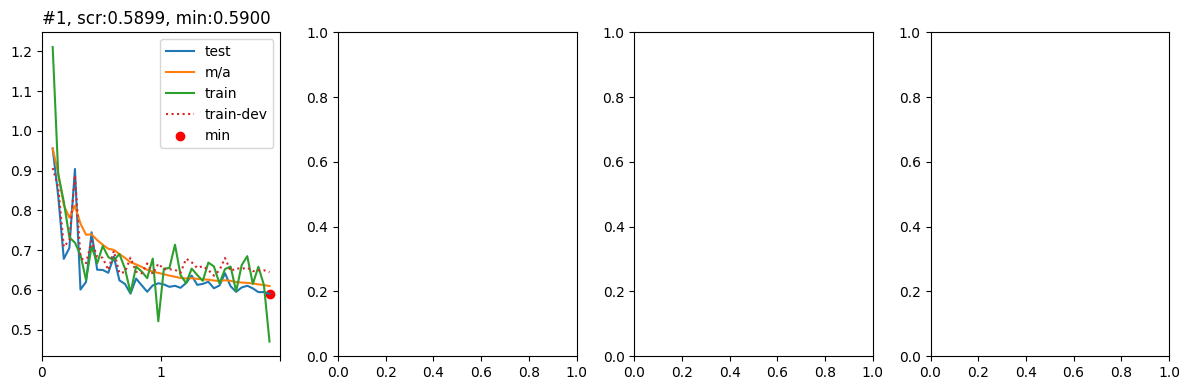

In [17]:
# def cross_validation():
with open(prompts_train_path, encoding='utf-8') as f:
    prompts = pd.read_csv(f)
#     prompts = prompts[prompts.prompt_id != '3b9047'].reset_index(drop=True)

plt.figure(figsize=(12,4))

folds_list = list(prompts.prompt_id)
score_type = 'wording'
batch_size = 8
lr = 1e-04
lr_head = lr
weight_decay = 1e-04
n_epochs = 2

scores_best = []
scores_fold = []

fig, axs = plt.subplots(1, len(folds_list), figsize=(12,4), layout='tight')

for i, fold in enumerate(folds_list, 1):
    train_loader, test_loader, train_dev_loader = loaders_init(score_type, batch_size, fold)

    fold_score, best_score, n_iter, test_losses, train_losses, train_dev_losses = train_model(n_epochs,
                                                                                              lr, weight_decay,
                                                                                              i, lr_head)
    scores_fold.append((fold_score))
    scores_best.append(best_score)

    axs[i-1] = axis_set(axs[i-1])

mean_best_score = np.mean(scores_best)
mean_fold_score = np.mean(scores_fold)

fig.suptitle(f'CV_best={mean_best_score:.5f}, CV_fold={mean_fold_score:.5f}, lr={lr}')
fig.savefig('res_figure.png', dpi=200)

In [ ]:
fig.set_figwidth(6)

In [ ]:
fig